<a href="https://colab.research.google.com/github/freakezoide/codigos-de-coolab/blob/main/fallecidos_en_accidentes_proyecto_a_chusmea_en_breve.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Configuración inicial
plt.style.use('ggplot')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)

# Cargar datos
df = pd.read_csv('fallecidos-nueva-2019.csv', encoding='latin-1')

# Preprocesamiento básico
df['Fechayhora'] = pd.to_datetime(df['Fechayhora'])
df['Año'] = df['Fechayhora'].dt.year
df['Mes'] = df['Fechayhora'].dt.month
df['Hora'] = df['Fechayhora'].dt.hour
df['DiaSemana'] = df['Fechayhora'].dt.day_name()

# Crear variable objetivo binaria para clasificación
df['Objetivo'] = np.where(df['FallecidoalosDias'] <= 3, 1, 0)

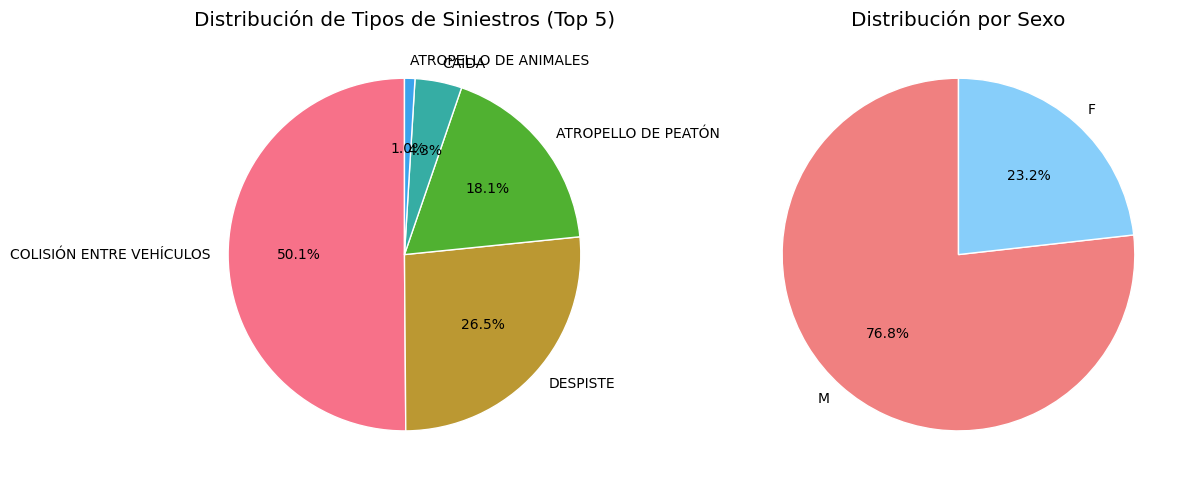

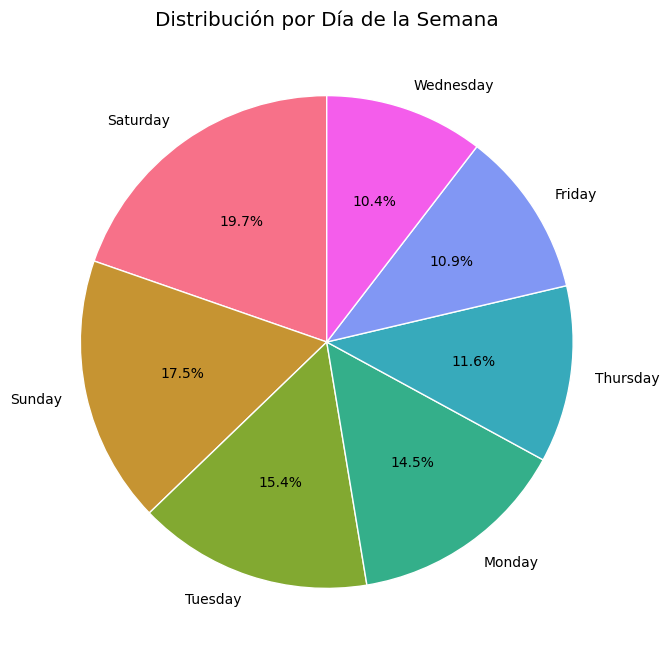

In [3]:
# =============================================
# 1. GRÁFICOS DE TORTA (PIE CHARTS)
# =============================================

# Gráfico de torta para la distribución de los siniestros
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
df['TipodeSiniestro'].value_counts().head(5).plot.pie(
    autopct='%1.1f%%',
    startangle=90,
    wedgeprops={'edgecolor': 'white', 'linewidth': 1},
    textprops={'fontsize': 10}
)
plt.title('Distribución de Tipos de Siniestros (Top 5)')
plt.ylabel('')

# Gráfico de torta para la distribución por sexo
plt.subplot(1, 2, 2)
df['Sexo'].value_counts().plot.pie(
    autopct='%1.1f%%',
    startangle=90,
    wedgeprops={'edgecolor': 'white', 'linewidth': 1},
    textprops={'fontsize': 10},
    colors=['lightcoral', 'lightskyblue']
)
plt.title('Distribución por Sexo')
plt.ylabel('')
plt.tight_layout()
plt.show()

# Gráfico de torta para días de la semana
plt.figure(figsize=(8, 8))
df['DiaSemana'].value_counts().plot.pie(
    autopct='%1.1f%%',
    startangle=90,
    wedgeprops={'edgecolor': 'white', 'linewidth': 1},
    textprops={'fontsize': 10},
    colors=sns.color_palette("husl", 7)
)
plt.title('Distribución por Día de la Semana')
plt.ylabel('')
plt.show()


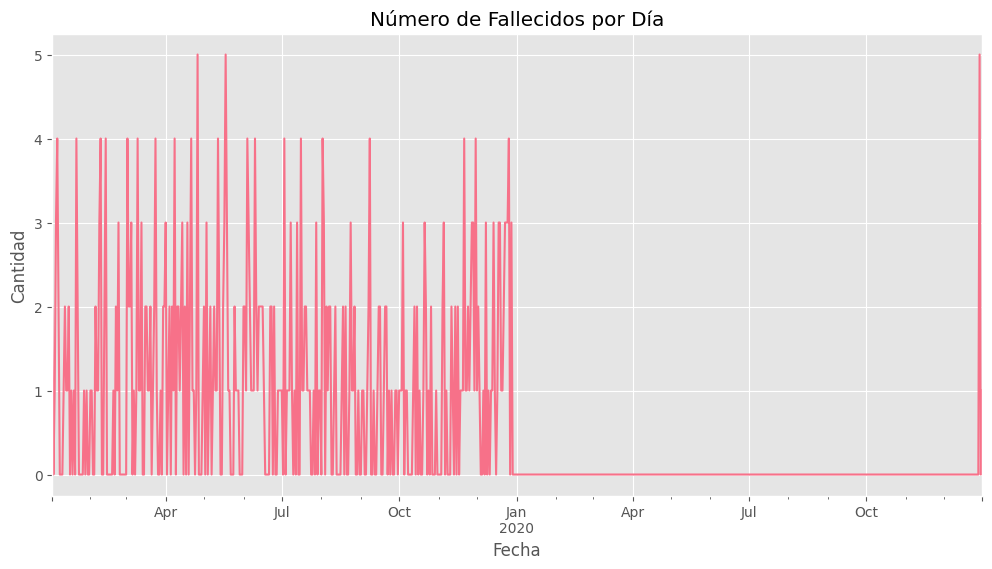

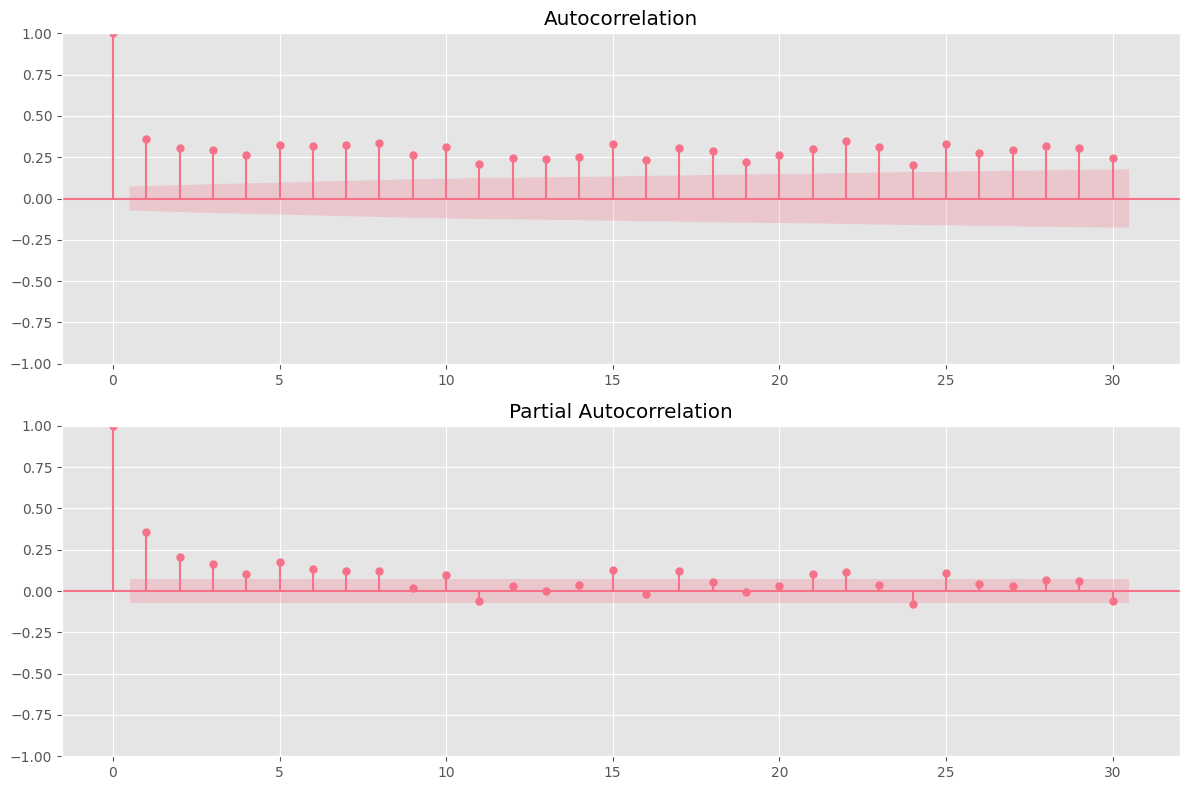

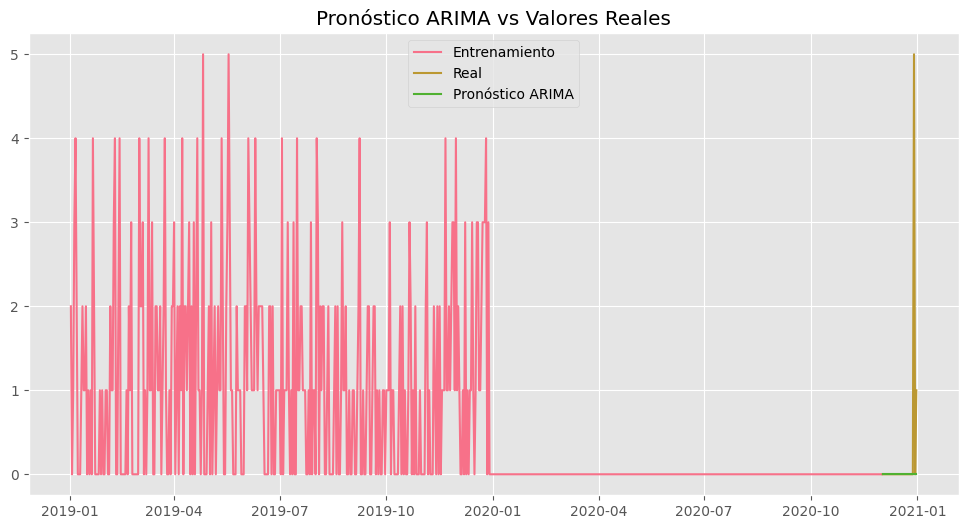

In [4]:
# =============================================
# 2. MODELO ARIMA PARA ANÁLISIS TEMPORAL
# =============================================

# Preparar datos para ARIMA (agrupados por fecha)
ts_data = df.set_index('Fechayhora').resample('D').size()

# Visualizar la serie temporal
plt.figure(figsize=(12, 6))
ts_data.plot()
plt.title('Número de Fallecidos por Día')
plt.xlabel('Fecha')
plt.ylabel('Cantidad')
plt.grid(True)
plt.show()

# Gráficos ACF y PACF para determinar parámetros ARIMA
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(ts_data, lags=30, ax=ax1)
plot_pacf(ts_data, lags=30, ax=ax2)
plt.tight_layout()
plt.show()

# Dividir en train y test (últimos 30 días para test)
train = ts_data[:-30]
test = ts_data[-30:]

# Entrenar modelo ARIMA (puedes ajustar los parámetros según ACF/PACF)
model_arima = ARIMA(train, order=(7, 1, 2))  # Ejemplo: ARIMA(7,1,2)
fitted_model = model_arima.fit()

# Pronóstico
forecast = fitted_model.forecast(steps=30)

# Visualizar pronóstico vs real
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Entrenamiento')
plt.plot(test.index, test, label='Real')
plt.plot(test.index, forecast, label='Pronóstico ARIMA')
plt.title('Pronóstico ARIMA vs Valores Reales')
plt.legend()
plt.grid(True)
plt.show()


<ipython-input-5-ef423451a1b0>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = le.fit_transform(X[col].astype(str))
<ipython-input-5-ef423451a1b0>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = le.fit_transform(X[col].astype(str))
<ipython-input-5-ef423451a1b0>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

Accuracy del modelo: 87.40%

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        15
           1       0.88      0.99      0.93       112

    accuracy                           0.87       127
   macro avg       0.44      0.50      0.47       127
weighted avg       0.78      0.87      0.82       127



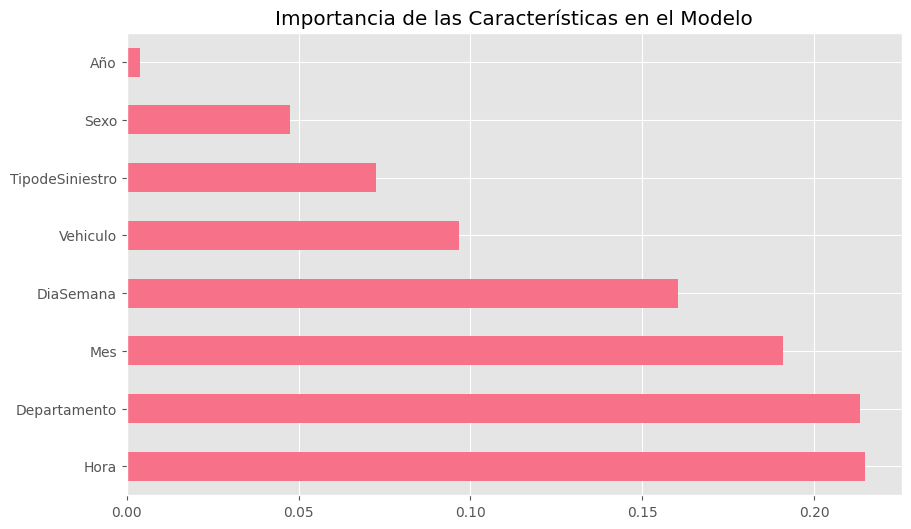

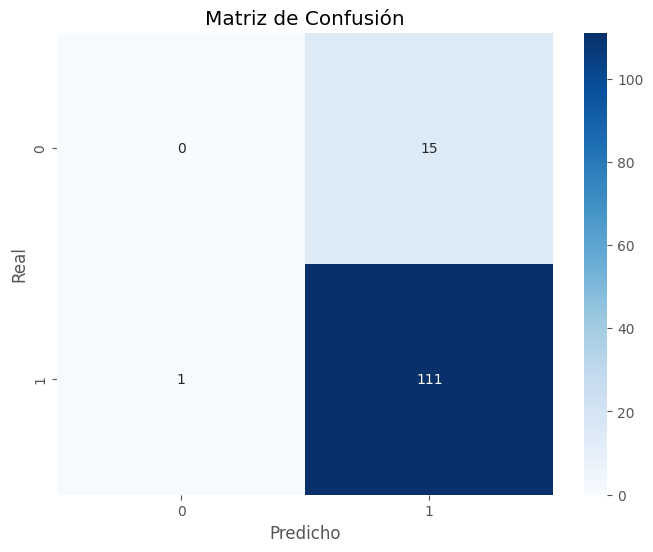

In [5]:
# =============================================
# 3. MODELO DE CLASIFICACIÓN (Random Forest)
# =============================================

# Seleccionar características relevantes
features = ['TipodeSiniestro', 'Vehiculo', 'Sexo', 'Departamento', 'Año', 'Mes', 'Hora', 'DiaSemana']
X = df[features]
y = df['Objetivo']

# Preprocesamiento: Codificación de variables categóricas
categorical_features = ['TipodeSiniestro', 'Vehiculo', 'Sexo', 'Departamento', 'DiaSemana']
for col in categorical_features:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

# Dividir datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Crear y entrenar modelo
model = RandomForestClassifier(n_estimators=300,
                              max_depth=15,
                              min_samples_split=3,
                              random_state=42,
                              class_weight='balanced')

model.fit(X_train, y_train)

# Evaluar modelo
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy del modelo: {accuracy:.2%}")

# Mostrar reporte de clasificación
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))

# Visualización de importancia de características
plt.figure(figsize=(10, 6))
feature_importance = pd.Series(model.feature_importances_, index=X.columns)
feature_importance.nlargest(10).plot(kind='barh')
plt.title('Importancia de las Características en el Modelo')
plt.show()

# Matriz de confusión
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()